# Fitting a Hologram

This notebook shows how to load a pre-recorded hologram of a colloidal sphere
into a Feature object and analyze it with Lorenz-Mie theory. The analysis yields
the radius of the sphere, the refractive index of the sphere, and the sphere's
three-dimensional location relative to the center of the imaging plane.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

from pylorenzmie.analysis import Feature
from pylorenzmie.theory import (LMHologram, coordinates)

First, we instantiate a Feature() object using the standard Lorenz-Mie model for hologram formation. The model includes a description of the holographic microscope that records the images we wish to analyze. In this example, we specify that the instrument illuminates the sample with blue light at a vacuum wavelength of $\lambda$ = 0.447 μm and has a system magnification of 0.048 μm/pixel. For particles dispersed in water, the refractive index of the medium is $n_m$ = 1.340 at the imaging wavelength. These calibration constants may differ for different hardware implementations.
The commercial xSight instrument, for example uses a system magnification of 0.120 μm/pixel.

In [2]:
feature = Feature(model=LMHologram(double_precision=False))

# Instrument configuration
ins = feature.model.instrument
ins.wavelength = 0.447     # [um]
ins.magnification = 0.048  # [um/pixel]
ins.n_m = 1.34

Next, we load the (normalized) hologram we wish to fit. In the present example, we use OpenCV to load a pre-recorded hologram that was saved as a PNG image. We convert the image to grayscale and normalize it by the mean value. This hologram was cropped from a larger image. Since we are not interested in locating the particle within the original image, we provide the model with a standard coordinate system using the coordinates() helper function. We finally can provide the normalized image data to the Feature() object for analysis.

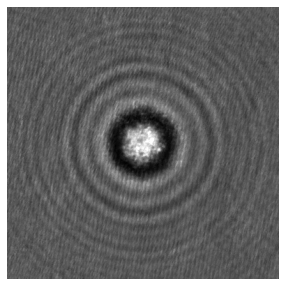

In [3]:
# Read example image
img = cv2.imread('tutorials/crop.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float)

# The normalized image constitutes the data for the Feature()
feature.data = img / np.mean(img)

# Specify the coordinates for the pixels in the image data
feature.model.coordinates = coordinates(img.shape)

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(img, cmap='gray')
ax.axis('off');

The nonlinear least-squares fit requires initial estimates for the sphere's radius, $a_p$,
refractive index, $n_p$, and three-dimensional position $\mathbf{r}_p$.

In this example, we know the true values for this hologram, so we add random offsets to give the fitter a challenge.

Sphere(a_p=1.0602640056298722, n_p=1.4168241063037577, k_p=0.0, r_p=[195.70469274304037, 196.49517080918724, 402.0057408809257])


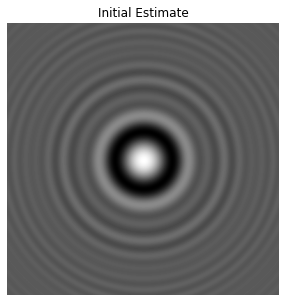

In [4]:
# Initial estimates for particle properties
p = feature.model.particle
p.r_p = [img.shape[0]//2, img.shape[1]//2, 330.]
p.a_p = 1.1
p.n_p = 1.4
# add errors to parameters
p.r_p += np.random.normal(0., 1, 3)
p.z_p += np.random.normal(0., 30, 1)
p.a_p += np.random.normal(0., 0.1, 1)
p.n_p += np.random.normal(0., 0.04, 1)
print(p)

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(feature.model.hologram().reshape(img.shape), cmap='gray')
ax.axis('off')
ax.set_title('Initial Estimate');

Before fitting, we adjust the settings for the optimizer. Fitting to every pixel in this 390$\times$390 pixel image is computationally expensive and is not necessary to obtain precise values for the fitting parameters. The optimizer uses a mask to specifies which pixels to fit. In this case, we tell the optimizer to only fit to 10% of the pixels in the image. The distribution "fast" simply chooses these pixels at random.

In [5]:
feature.optimizer.mask.percentpix = 0.1
feature.optimizer.mask.distribution = 'donut'

Finally, we can fit the image to predictions of the Lorenz-Mie theory of light scattering to optimize the particle's radius, refractive index and three-dimensional position. The method name "lm" refers to the Levenberg-Marquardt gradient descent algorithm, and is essentially a pixel-by-pixel least-squares fit. 

When we obtain our result, we can print it to get the fitted parameters as well as some information about the fitting process. "redchi" or Reduced $\chi^2$ is a measure of how closely the fitted hologram matches with the original image. This can also be examined visually by looking at the residuals (rightmost plot).

"nfev" stands for "number of function evaluations" and tells how many iterations of the calculation were needed to obtain the answer.

In [6]:
result = feature.optimize(method='lm', robust='False')
print(result)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.45673706166753153
nfev: 31
x_p: 193.76501 (init: 195.70469)
y_p: 194.64780 (init: 196.49517)
z_p: 371.09985 (init: 402.00574)
a_p: 1.11273 (init: 1.06026)
n_p: 1.41192 (init: 1.41682)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.04800 (init: 0.04800) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)



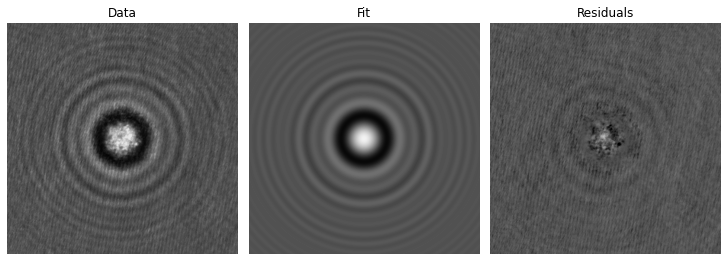

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)

vmin = np.min(feature.data) * 0.9
vmax = np.max(feature.data) * 1.1
style = dict(vmin=vmin, vmax=vmax, cmap='gray')

images = [feature.data,
          feature.model.hologram().reshape(img.shape),
          feature.residuals()+1]
labels = ['Data', 'Fit', 'Residuals']

for ax, image, label in zip(axes, images, labels):
    ax.imshow(image, **style)
    ax.axis('off')
    ax.set_title(label)

In [8]:
print(feature.model.method, feature.model.double_precision)

cupy False
